In [2]:
import pandas as pd 
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import re
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

In [3]:
stopwords = set(stopwords.words('english'))

In [4]:
df = pd.read_csv('fake_job_postings.csv')

In [5]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
df.shape

(17880, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [8]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df=df[['description','title','location','fraudulent']].copy()

In [10]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    text = text.lower()
    tokens = [w for w in text.split() if w not in stopwords and len(w) > 1]
    return " ".join(tokens)

In [11]:
df['text']=(df['title'].fillna('')+' '+df['description'].fillna('')).map(clean_text)

In [12]:
df['label']=df['fraudulent'].astype(int)

In [13]:
df=df[['text','label']].sample(frac=1,random_state=42).reset_index(drop=True)

In [21]:
X = df['text']
y = df['label']

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

print('Train size', X_train.shape[0])
print('Validation size', X_val.shape[0])
print('Test size', X_test.shape[0])

Train size 10728
Validation size 3576
Test size 3576


In [22]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=8000, ngram_range=(1,2))),
    ('clf',LogisticRegression(max_iter=1000,class_weight='balanced'))
])

pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=8000, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [23]:
y_pred = pipe.predict(X_val)

print(classification_report(y_val,y_pred,digits=4))
print('Confusion matrix:\n',confusion_matrix(y_val,y_pred))

              precision    recall  f1-score   support

           0     0.9915    0.9644    0.9778      3403
           1     0.5451    0.8382    0.6606       173

    accuracy                         0.9583      3576
   macro avg     0.7683    0.9013    0.8192      3576
weighted avg     0.9699    0.9583    0.9625      3576

Confusion matrix:
 [[3282  121]
 [  28  145]]


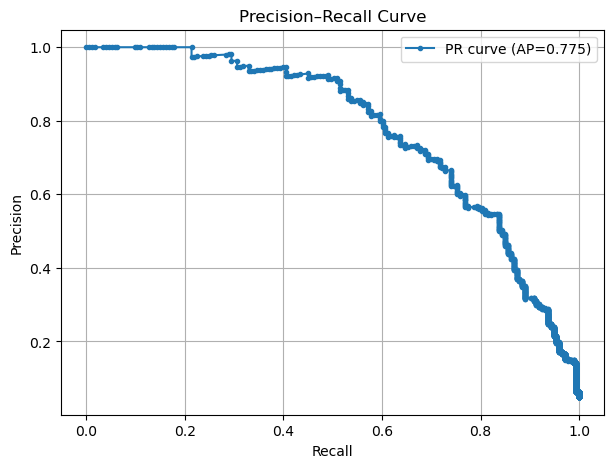

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Probabilities for the positive class (fake = 1)
y_proba = pipe.predict_proba(X_val)[:, 1]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

# Average precision (area under PR curve)
ap = average_precision_score(y_val, y_proba)

# Plot
plt.figure(figsize=(7,5))
plt.plot(recall, precision, marker='.', label=f'PR curve (AP={ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
from sklearn.metrics import roc_auc_score

y_test_proba = pipe.predict_proba(X_test)[:, 1]

y_test_pred = (y_test_proba >= 0.5).astype(int) 

print(classification_report(y_test, y_test_pred, digits=4))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred))
print('ROC:', roc_auc_score(y_test, y_test_proba))

              precision    recall  f1-score   support

           0     0.9882    0.9586    0.9732      3403
           1     0.4873    0.7746    0.5982       173

    accuracy                         0.9497      3576
   macro avg     0.7377    0.8666    0.7857      3576
weighted avg     0.9640    0.9497    0.9550      3576

Confusion Matrix:
 [[3262  141]
 [  39  134]]
ROC: 0.934439010801418


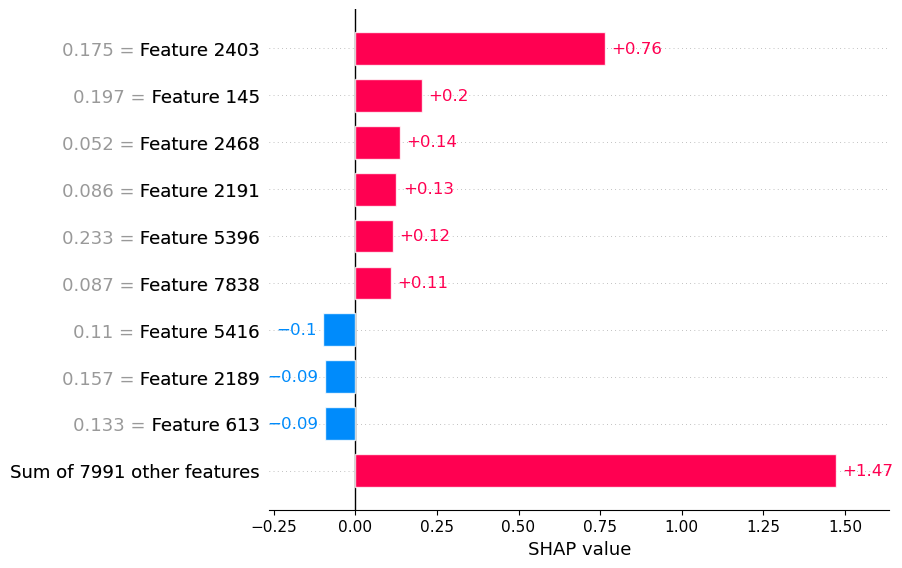

In [31]:
import shap
explainer = shap.Explainer(pipe.named_steps['clf'],pipe.named_steps['tfidf'].transform(X_val))
shap_values = explainer(pipe.named_steps['tfidf'].transform([X_val.iloc[0]]))
shap.plots.bar(shap_values[0])

In [33]:
joblib.dump(pipe,'fake_job_detector.pkl')

['fake_job_detector.pkl']